## IMPORT

In [7]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import fmin_l_bfgs_b 
from cvxopt import matrix, solvers

In [8]:
Xtr = np.array(pd.read_csv('data_image/Xtr.csv',header=None,sep=',',usecols=range(3072))) 
Xte = np.array(pd.read_csv('data_image/Xte.csv',header=None,sep=',',usecols=range(3072))) 
Ytr = np.array(pd.read_csv('data_image/Ytr.csv',sep=',',usecols=[1])).squeeze() 

## VIZUALISATION

Let's visualize data :

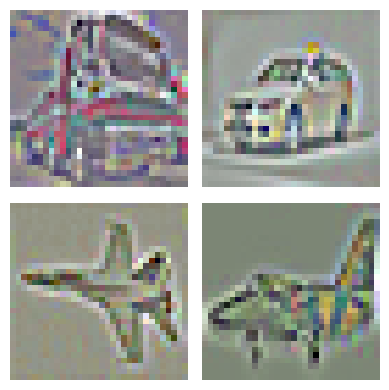

In [9]:
def plot_images_grid(data, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2, nrows*2))
    random=np.random.choice(data.shape[0],size=nrows*ncols)
    #data=(data-np.min(data))/(np.max(data)-np.min(data))
    for j, ax in enumerate(axes.flat):
        i=random[j]
        if i < data.shape[0]:
            image_data = data[i, :]
            
            # Normaliser les données dans l'intervalle [0, 1]
            # min_val = image_data.min()
            # max_val = image_data.max()
            # print(min_val,max_val)
            # image_data = (image_data - min_val) / (max_val - min_val)
            # print(image_data.max())
            
            red_channel = image_data[:1024].reshape((32, 32))
            red_channel=(red_channel-red_channel.min())/(red_channel.max()-red_channel.min())
            green_channel = image_data[1024:2048].reshape((32, 32))
            green_channel=(green_channel-green_channel.min())/(green_channel.max()-green_channel.min())
            blue_channel = image_data[2048:].reshape((32, 32))
            blue_channel=(blue_channel-blue_channel.min())/(blue_channel.max()-blue_channel.min())
            image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

            ax.imshow(image)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_images_grid(Xtr,2,2)

## KERNELS

Let's define some kernels :

In [10]:
def noyau_gauss(X,sigma=1):
    """
    Compute the matrix of the Gaussian Kernel : 
    
    (K)_ij=K(X_i,X_j)=exp( 1/2*sigma^2 * ||X_i-X_j||^2 ) the Gaussian Kernel evaluated between the ith data and jth data

    Parameters : 
    X : 2d array size (n,p) 
        the Data matrix with n the number of data and p the size of data
    sigma : float 
             Variance of the GaussianKernel 

    Outputs :
    2d array size (n,n)
    Matrix of the Gaussian Kernel
    """
    
    return np.exp(-np.sum(X-X[:,None,:],axis=-1)/(2*sigma**2))

In [11]:
def polynomial_kernel(X,d=2):
    """
    Compute the matrix of the Polynomial Kernel : 
    
    (K)_ij=K(X_i,X_j)=(<X_i,X_j>)^d the Polynomial Kernel of degree d evaluated between the ith data and jth data

    Parameters : 
    X : 2d array size (n,p) 
        the Data matrix with n the number of data and p the size of data
    d : Integer
            Degree of the polynomial kernel

    Outputs :
    2d array size (n,n)
    Matrix of the Gaussian Kernel
    """
    X_intercept = np.concatenate((X,np.ones(X.shape[0]).reshape(-1,1)), axis=1)
    return np.sum(X_intercept * X_intercept[:,None,:], axis=-1)**d

## MODELS

In [12]:
class Kernel_ridge_reg():
    """
    Class which comput the solution to the Kernel Ridge Regression with regularization parameter lambda (lmbda)

    ----> We have a close form for the solution : 
            alpha=(K+lambda*n*I)^-1y
            pred=K@alpha
    """

    def __init__(self,lmbda):
        self.lmbda=lmbda

    def train(self,K,y):
        mat=K+self.lmbda*K.shape[0]*np.identity(K.shape[0])
        self.alpha=scipy.linalg.solve(mat,y)
    
    def fit(self,K):
        return K@self.alpha

In [13]:
class Kernel_logistic_reg():
    """
    Class which comput the solution to the Kernel logistic Regression with regularization parameter lambda (lmbda)

    ----> We have to solve the smooth convex opti problem : 
            alpha=argmin 1/n sum_i=1^n logisitic(y_i[Kalpha]_i)+lambda/2 *alpha^T@K@alpha

          We solve this with the L-FBGS form scipy

          and then : 
            pred=K@alpha
    """

    def __init__(self,lmbda,alpha0):
        self.lmbda=lmbda
        self.alpha0=alpha0

    def obj(self,K,y,alpha):
        n=len(K)
        return np.sum(np.log(1+np.exp(-y*(K@alpha))))/n+self.lmbda*alpha.T@K@alpha/2

    def derivative(self,K,y,alpha):
        n=len(K)
        P=-np.diag(1/(1+np.exp(y*(K@alpha))))
        return K@P@y/n+self.lmbda*K@alpha

    def train(self,K,y):
        ob= lambda alpha : self.obj(K=K,y=y,alpha=alpha)
        der=lambda alpha : self.derivative(K=K,y=y,alpha=alpha)
        alpha,_,_=fmin_l_bfgs_b(ob, self.alpha0, der, args=(), pgtol=1e-50, factr =1e-50)
        self.alpha=alpha
    
    def fit(self,K):
        return K@self.alpha

In [14]:
class SVM():
     """
    Class which train SVM models with Kernels methods takes a dataset with labels in {-1,1} 

    """
     def __init__(self,lmbda):
          self.lmbda = lmbda

     def train(self,K,y):
          """ 
          We want to solve max mu^T@1 - 1/4*lambda mu^t@diag(y)@K@diag(y)@mu for 0<=mu<=1/n
          and then we have :
               alpha=diag(y)@mu/2*lambda

          We use the package cvxopt wich solve : 
               min 1/2x^T@P@x + q^T@x for Gx<=h and Ax=b
          """
          n=len(K)

          q = -np.ones(n)
          P = np.diag(y) @ K @np.diag(y) / (2*self.lmbda)
          G = np.concatenate((np.identity(n),-np.identity(n)),axis=0)
          h = np.concatenate((np.ones(n)/n , np.zeros(n)),axis=0)[:,None]

          mu=solvers.qp(P=matrix(P),q=matrix(q),G=matrix(G),h=matrix(h))['x']
          
          self.alpha=np.diag(y)@mu / (2*self.lmbda)
     
     def fit(self,K):
          return np.sign(K@self.alpha)
     
     def pred_prob(self,K):
          return K@self.alpha
     


## UTILS FUNCTION

In [15]:
def create_reduce_dataset(X,Y,k,size):
    """ 
    Create a dataset of size = 18*size with 50% of class k and 50% random classes  
    
    and transform the labels of class k in 1 and the labels of the others classes in -1 
    """

    Y_new=np.array([])
    X_new=np.random.randint(2,size=(1,X.shape[1]))

    for i in range(len(np.unique(Y))):
        if i == k :
            ind=np.random.choice(np.array(np.where(Y==i))[0],size=size*9)
        else :
            ind=np.random.choice(np.array(np.where(Y==i))[0],size=size)
        X_new=np.concatenate((X_new,X[ind]))
        if i==k:
            Y_new=np.concatenate((Y_new,np.ones(size*9)))
        else :
            Y_new=np.concatenate((Y_new,-np.ones(size)))
            
    X_new=X_new[1:]
    ind=np.arange(Y_new.shape[0])
    np.random.shuffle(ind)
    Y_shuffled=Y_new[ind]
    X_shuffled=X_new[ind]
    return X_shuffled,Y_shuffled

In [16]:
def accuracy(y_pred,y_test):
    return np.sum(y_pred==y_test)/len(y_pred)

## RUN CODE

Let's try with the class k=4 and a dataset of size train : 600 and test : 300 

The goal is that the classifier classify well the class k from the others class 

In [17]:
X,Y=create_reduce_dataset(Xtr,Ytr,k=4,size=50)
X_train=X[:600]
X_test=X[600:900]
Y_train=Y[:600]
Y_test=Y[600:900]
Big_X=np.concatenate((X_train,X_test),axis=0)

Let's compute the Grams Matrix (let's try with polynomial kernel), it takes a lot of time (1min40 for 900x900 kernel) : 

In [18]:
K = polynomial_kernel(Big_X)
K_train = K[:len(X_train),:len(X_train)]
K_test = K[len(X_train):,:len(X_train)]

Let's try differents models : 

In [33]:
# RIDGE REG not very appropriated for the problem (classification != regression )
classifier=Kernel_ridge_reg(lmbda=0.1)

classifier.train(K_train,Y_train) 

Y_pred = classifier.fit(K_test)

accuracy(np.sign(Y_pred),Y_test)

0.6233333333333333

In [27]:
# Logistic REG 
classifier=Kernel_logistic_reg(lmbda=0.1,alpha0=np.random.rand(len(X_train)))

classifier.train(K_train,Y_train)

Y_pred = classifier.fit(K_test)

accuracy(np.sign(Y_pred),Y_test)

0.5733333333333334

In [32]:
classifier=SVM(lmbda=0.2)

classifier.train(K_train,Y_train)

Y_pred = classifier.fit(K_test)

accuracy(Y_pred[:,0],Y_test)

     pcost       dcost       gap    pres   dres
 0: -5.6818e+00 -6.2326e+00  1e+03  4e+01  1e-15
 1: -5.5514e+00 -5.3951e+00  9e+01  3e+00  7e-16
 2: -3.1908e+00 -2.3902e+00  1e+01  3e-01  9e-16
 3: -9.5433e-01 -1.6593e+00  1e+00  1e-02  2e-15
 4: -9.0197e-01 -9.6369e-01  6e-02  1e-04  5e-16
 5: -9.2854e-01 -9.3046e-01  2e-03  4e-06  4e-16
 6: -9.2941e-01 -9.2945e-01  4e-05  7e-08  4e-16
 7: -9.2943e-01 -9.2943e-01  4e-07  7e-10  4e-16
Optimal solution found.


0.5333333333333333

Let's try to do a loop and attributing an SVM for all classes : 